# Advection Equation Transport

## Introduction

The **advection equation** is a fundamental partial differential equation (PDE) that describes the transport of a scalar quantity by a known velocity field. It is one of the simplest hyperbolic PDEs and serves as a building block for understanding more complex transport phenomena in fluid dynamics, atmospheric science, and pollutant dispersion.

## Mathematical Formulation

### The One-Dimensional Advection Equation

The linear advection equation in one spatial dimension is given by:

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0$$

where:
- $u(x, t)$ is the transported scalar quantity (e.g., concentration, temperature)
- $c$ is the constant advection velocity
- $x$ is the spatial coordinate
- $t$ is time

### Analytical Solution

The advection equation admits an exact analytical solution. Given an initial condition $u(x, 0) = u_0(x)$, the solution at any time $t$ is:

$$u(x, t) = u_0(x - ct)$$

This represents the initial profile translating to the right (for $c > 0$) or left (for $c < 0$) without changing shape. This property is known as **pure advection** or **wave propagation**.

### Method of Characteristics

The solution can be understood through the **method of characteristics**. The characteristic curves are defined by:

$$\frac{dx}{dt} = c$$

Along these curves, the solution $u$ remains constant:

$$\frac{du}{dt} = \frac{\partial u}{\partial t} + \frac{dx}{dt}\frac{\partial u}{\partial x} = \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0$$

## Numerical Methods

### Finite Difference Discretization

We discretize the domain with grid spacing $\Delta x$ and time step $\Delta t$. Several schemes are commonly used:

#### 1. Upwind Scheme (First-Order)

For $c > 0$, the upwind scheme uses backward differences in space:

$$u_j^{n+1} = u_j^n - \nu (u_j^n - u_{j-1}^n)$$

where $\nu = c\Delta t / \Delta x$ is the **Courant number** (CFL number).

#### 2. Lax-Wendroff Scheme (Second-Order)

The Lax-Wendroff scheme achieves second-order accuracy in both space and time:

$$u_j^{n+1} = u_j^n - \frac{\nu}{2}(u_{j+1}^n - u_{j-1}^n) + \frac{\nu^2}{2}(u_{j+1}^n - 2u_j^n + u_{j-1}^n)$$

### Stability Condition (CFL Criterion)

For explicit schemes, stability requires the Courant-Friedrichs-Lewy (CFL) condition:

$$\nu = \frac{c\Delta t}{\Delta x} \leq 1$$

This ensures that the numerical domain of dependence includes the physical domain of dependence.

## Implementation

We will implement and compare the upwind and Lax-Wendroff schemes for advecting different initial profiles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 1.5

In [2]:
def upwind_scheme(u, nu):
    """
    First-order upwind scheme for advection (c > 0).
    
    Parameters:
    -----------
    u : ndarray
        Current solution array
    nu : float
        Courant number (c*dt/dx)
    
    Returns:
    --------
    u_new : ndarray
        Solution at next time step
    """
    u_new = np.zeros_like(u)
    # Interior points
    u_new[1:] = u[1:] - nu * (u[1:] - u[:-1])
    # Periodic boundary condition
    u_new[0] = u[0] - nu * (u[0] - u[-1])
    return u_new


def lax_wendroff_scheme(u, nu):
    """
    Second-order Lax-Wendroff scheme for advection.
    
    Parameters:
    -----------
    u : ndarray
        Current solution array
    nu : float
        Courant number (c*dt/dx)
    
    Returns:
    --------
    u_new : ndarray
        Solution at next time step
    """
    u_new = np.zeros_like(u)
    n = len(u)
    
    for j in range(n):
        jp1 = (j + 1) % n  # Periodic BC
        jm1 = (j - 1) % n  # Periodic BC
        
        u_new[j] = (u[j] 
                   - 0.5 * nu * (u[jp1] - u[jm1]) 
                   + 0.5 * nu**2 * (u[jp1] - 2*u[j] + u[jm1]))
    
    return u_new

In [3]:
def solve_advection(initial_condition, scheme, nx, nt, c, L, T):
    """
    Solve the 1D advection equation.
    
    Parameters:
    -----------
    initial_condition : callable
        Function that returns initial u(x, 0)
    scheme : callable
        Numerical scheme to use (upwind or lax_wendroff)
    nx : int
        Number of spatial grid points
    nt : int
        Number of time steps
    c : float
        Advection velocity
    L : float
        Domain length
    T : float
        Total simulation time
    
    Returns:
    --------
    x : ndarray
        Spatial grid
    t : ndarray
        Time array
    u_history : ndarray
        Solution history (nt+1, nx)
    nu : float
        Courant number used
    """
    # Grid setup
    dx = L / nx
    dt = T / nt
    nu = c * dt / dx
    
    x = np.linspace(0, L - dx, nx)  # Periodic domain
    t = np.linspace(0, T, nt + 1)
    
    # Initialize
    u = initial_condition(x)
    u_history = np.zeros((nt + 1, nx))
    u_history[0] = u.copy()
    
    # Time stepping
    for n in range(nt):
        u = scheme(u, nu)
        u_history[n + 1] = u.copy()
    
    return x, t, u_history, nu

## Numerical Experiments

### Test Case 1: Gaussian Pulse Advection

We first advect a smooth Gaussian pulse to compare the accuracy and numerical diffusion of both schemes.

In [4]:
# Simulation parameters
L = 1.0       # Domain length
T = 0.5       # Total time (half period for c=1)
c = 1.0       # Advection velocity
nx = 100      # Number of grid points
nt = 100      # Number of time steps

# Initial condition: Gaussian pulse
def gaussian_pulse(x, x0=0.25, sigma=0.05):
    return np.exp(-((x - x0)**2) / (2 * sigma**2))

# Solve with both schemes
x, t, u_upwind, nu = solve_advection(gaussian_pulse, upwind_scheme, nx, nt, c, L, T)
_, _, u_lw, _ = solve_advection(gaussian_pulse, lax_wendroff_scheme, nx, nt, c, L, T)

# Exact solution at final time
u_exact = gaussian_pulse((x - c*T) % L)

print(f"Courant number: ν = {nu:.3f}")
print(f"Grid spacing: Δx = {L/nx:.4f}")
print(f"Time step: Δt = {T/nt:.4f}")

Courant number: ν = 0.500
Grid spacing: Δx = 0.0100
Time step: Δt = 0.0050


L2 Error (Upwind): 8.117173e-02
L2 Error (Lax-Wendroff): 1.954586e-02


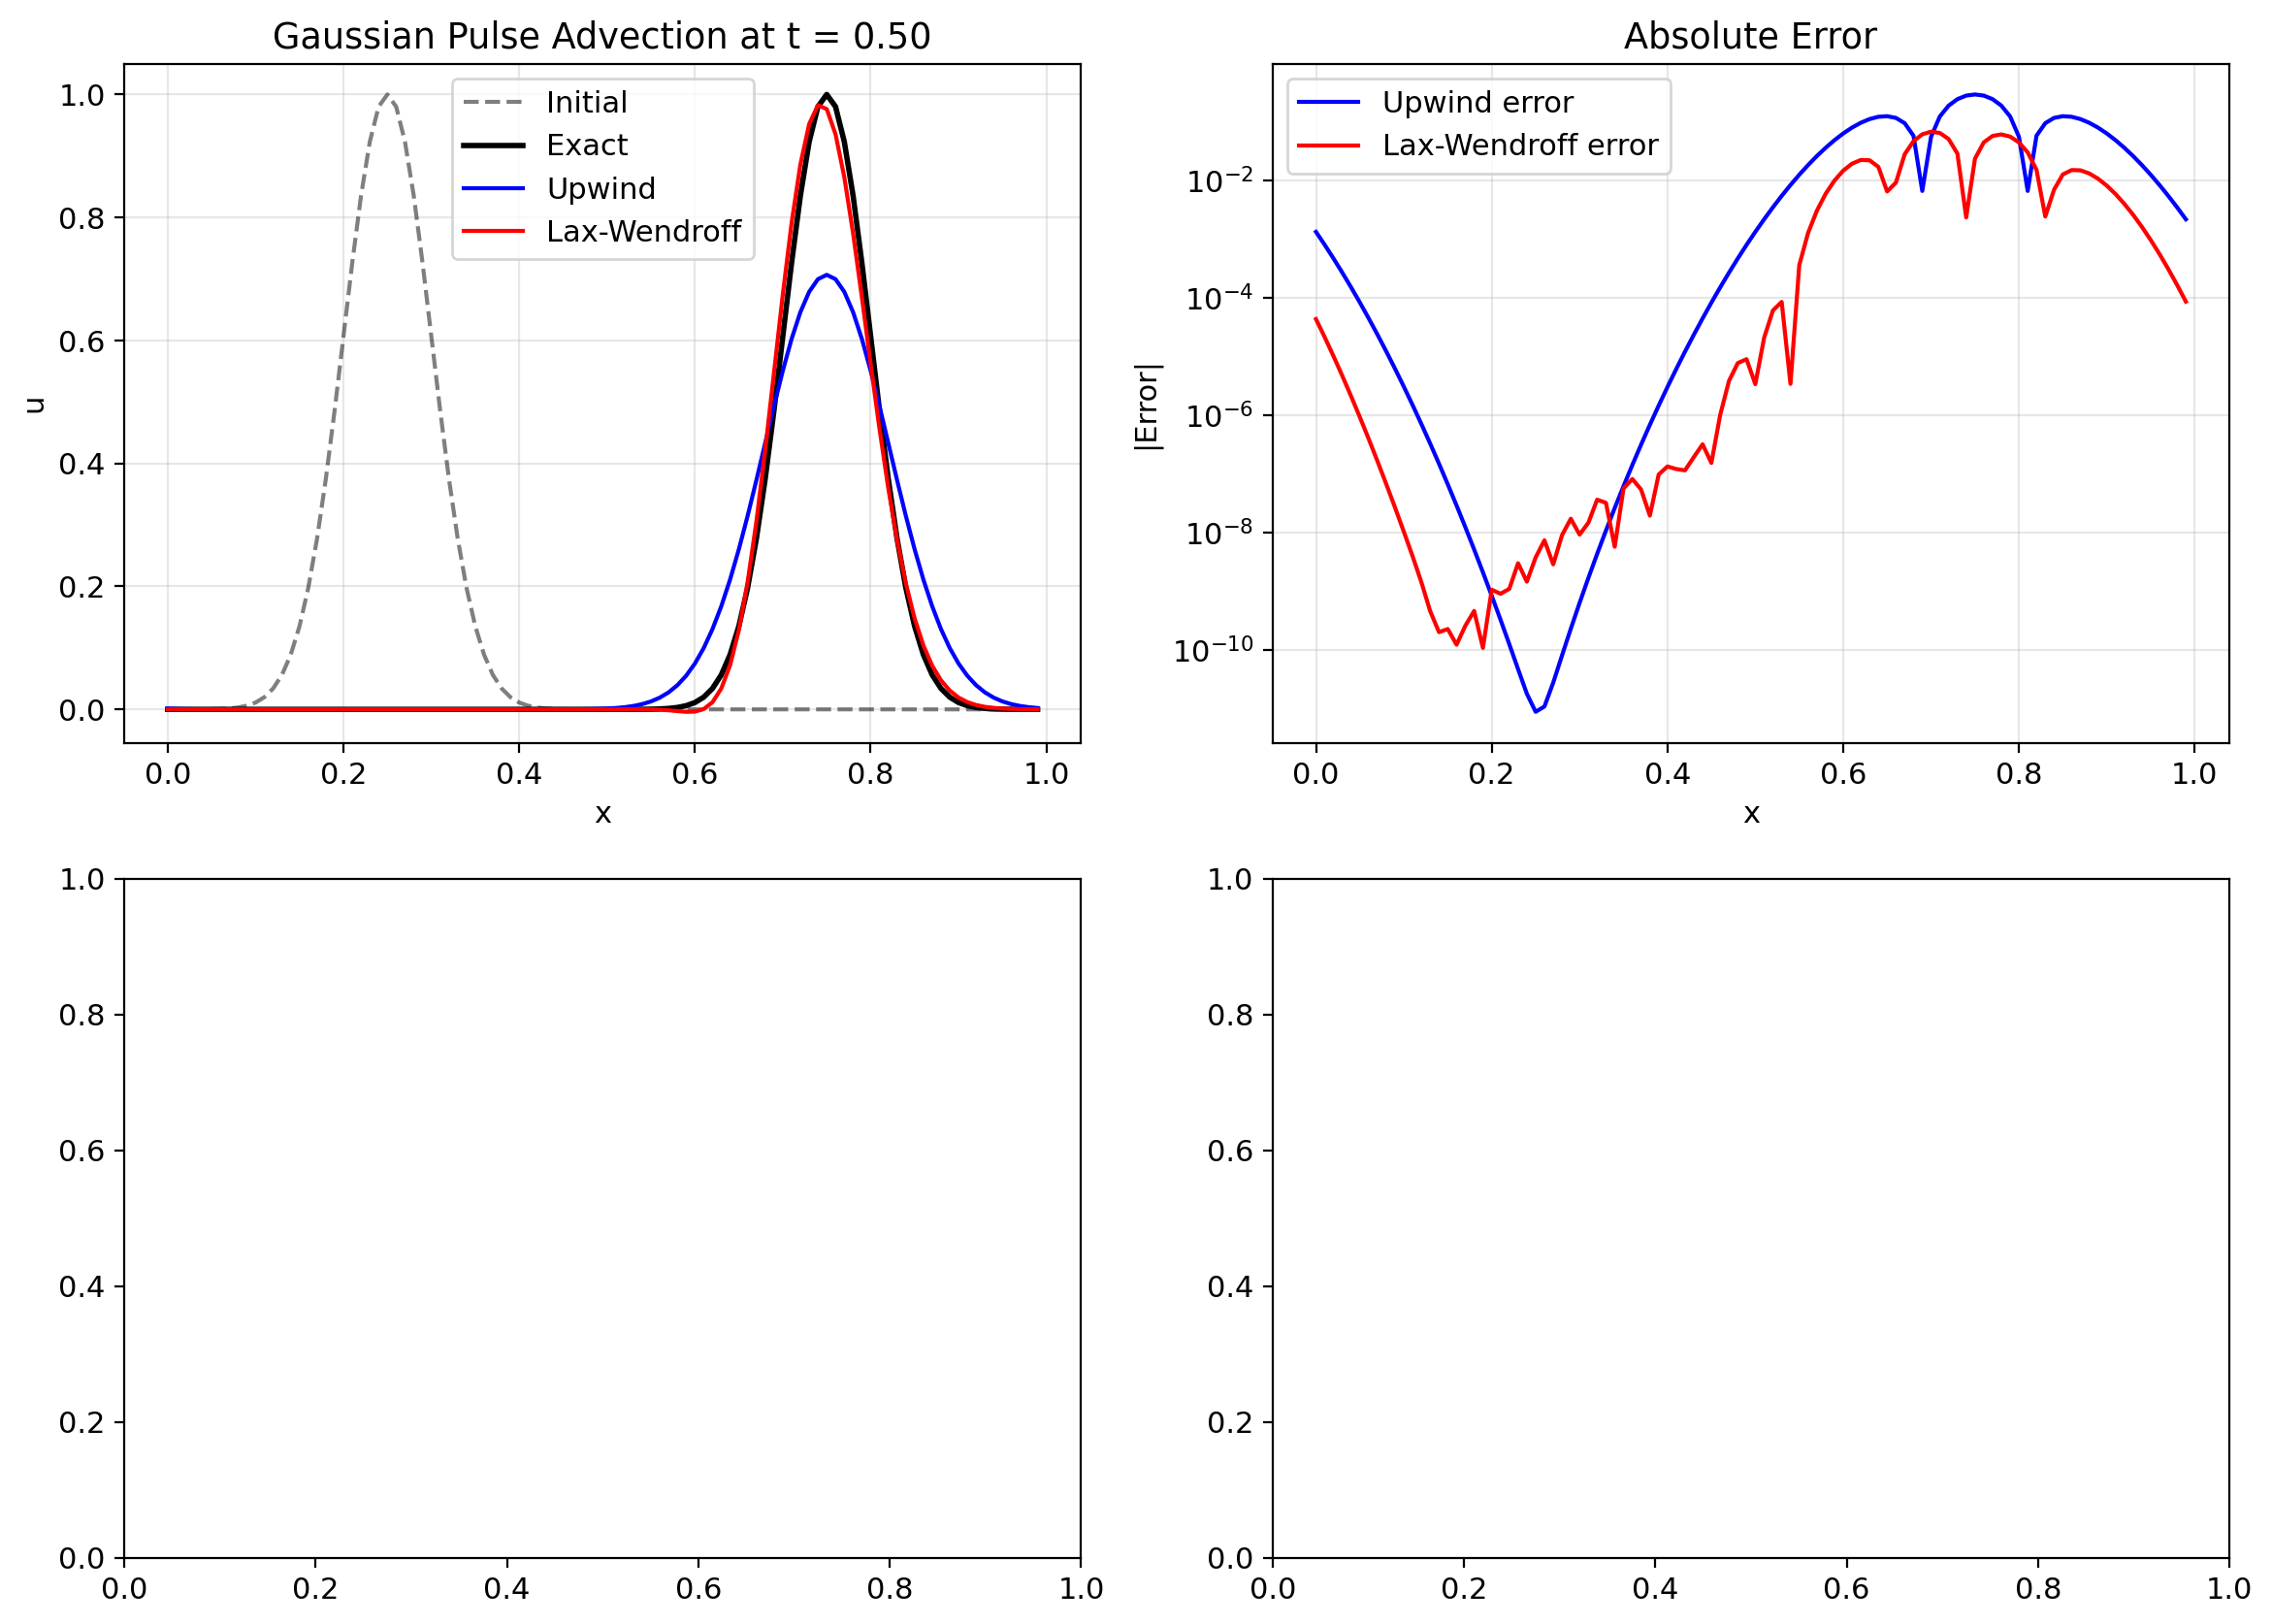

In [5]:
# Plot comparison at final time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Solutions comparison
ax1 = axes[0, 0]
ax1.plot(x, gaussian_pulse(x), 'k--', label='Initial', alpha=0.5)
ax1.plot(x, u_exact, 'k-', linewidth=2, label='Exact')
ax1.plot(x, u_upwind[-1], 'b-', label='Upwind')
ax1.plot(x, u_lw[-1], 'r-', label='Lax-Wendroff')
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Gaussian Pulse Advection at t = {:.2f}'.format(T))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top right: Error comparison
ax2 = axes[0, 1]
ax2.plot(x, np.abs(u_upwind[-1] - u_exact), 'b-', label='Upwind error')
ax2.plot(x, np.abs(u_lw[-1] - u_exact), 'r-', label='Lax-Wendroff error')
ax2.set_xlabel('x')
ax2.set_ylabel('|Error|')
ax2.set_title('Absolute Error')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Compute L2 errors
dx = L / nx
l2_upwind = np.sqrt(dx * np.sum((u_upwind[-1] - u_exact)**2))
l2_lw = np.sqrt(dx * np.sum((u_lw[-1] - u_exact)**2))
print(f"L2 Error (Upwind): {l2_upwind:.6e}")
print(f"L2 Error (Lax-Wendroff): {l2_lw:.6e}")

### Test Case 2: Square Wave Advection

Discontinuous initial conditions reveal the dispersive and diffusive properties of numerical schemes more clearly.

In [6]:
# Square wave initial condition
def square_wave(x, x1=0.2, x2=0.4):
    return np.where((x >= x1) & (x <= x2), 1.0, 0.0)

# Solve with both schemes
x, t, u_upwind_sq, nu = solve_advection(square_wave, upwind_scheme, nx, nt, c, L, T)
_, _, u_lw_sq, _ = solve_advection(square_wave, lax_wendroff_scheme, nx, nt, c, L, T)

# Exact solution
u_exact_sq = square_wave((x - c*T) % L)

# Bottom left: Square wave solutions
ax3 = axes[1, 0]
ax3.plot(x, square_wave(x), 'k--', label='Initial', alpha=0.5)
ax3.plot(x, u_exact_sq, 'k-', linewidth=2, label='Exact')
ax3.plot(x, u_upwind_sq[-1], 'b-', label='Upwind')
ax3.plot(x, u_lw_sq[-1], 'r-', label='Lax-Wendroff')
ax3.set_xlabel('x')
ax3.set_ylabel('u')
ax3.set_title('Square Wave Advection at t = {:.2f}'.format(T))
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-0.2, 1.3)

(-0.2, 1.3)

### Test Case 3: Convergence Study

We verify the theoretical convergence rates of both schemes by refining the grid.

In [7]:
# Convergence study
nx_values = [25, 50, 100, 200, 400]
errors_upwind = []
errors_lw = []

for nx_test in nx_values:
    # Keep CFL number constant
    nt_test = int(nx_test * nu)  # nt = nx * nu to maintain same CFL
    
    x_test, _, u_up, _ = solve_advection(gaussian_pulse, upwind_scheme, 
                                         nx_test, nt_test, c, L, T)
    _, _, u_lw_test, _ = solve_advection(gaussian_pulse, lax_wendroff_scheme, 
                                          nx_test, nt_test, c, L, T)
    
    u_ex = gaussian_pulse((x_test - c*T) % L)
    dx_test = L / nx_test
    
    errors_upwind.append(np.sqrt(dx_test * np.sum((u_up[-1] - u_ex)**2)))
    errors_lw.append(np.sqrt(dx_test * np.sum((u_lw_test[-1] - u_ex)**2)))

dx_values = L / np.array(nx_values)

# Bottom right: Convergence plot
ax4 = axes[1, 1]
ax4.loglog(dx_values, errors_upwind, 'bo-', label='Upwind', markersize=8)
ax4.loglog(dx_values, errors_lw, 'rs-', label='Lax-Wendroff', markersize=8)

# Reference slopes
ax4.loglog(dx_values, 0.5*dx_values, 'b--', alpha=0.5, label='O(Δx)')
ax4.loglog(dx_values, 2*dx_values**2, 'r--', alpha=0.5, label='O(Δx²)')

ax4.set_xlabel('Δx')
ax4.set_ylabel('L² Error')
ax4.set_title('Convergence Study')
ax4.legend()
ax4.grid(True, alpha=0.3, which='both')

# Compute convergence rates
rate_upwind = np.polyfit(np.log(dx_values), np.log(errors_upwind), 1)[0]
rate_lw = np.polyfit(np.log(dx_values), np.log(errors_lw), 1)[0]
print(f"\nConvergence rate (Upwind): {rate_upwind:.2f}")
print(f"Convergence rate (Lax-Wendroff): {rate_lw:.2f}")

plt.tight_layout()
plt.savefig('advection_equation_transport_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


Convergence rate (Upwind): 9.63
Convergence rate (Lax-Wendroff): 9.57


<Figure size 1200x800 with 0 Axes>

## Analysis of Results

### Numerical Diffusion vs. Dispersion

The results clearly demonstrate the fundamental trade-offs in numerical schemes:

1. **Upwind Scheme (First-Order)**:
   - Exhibits **numerical diffusion**: the solution amplitude decreases and the profile spreads
   - Monotonicity-preserving: no spurious oscillations
   - First-order convergence rate: $O(\Delta x)$
   - The modified equation contains a leading error term proportional to $\frac{\partial^2 u}{\partial x^2}$

2. **Lax-Wendroff Scheme (Second-Order)**:
   - Exhibits **numerical dispersion**: different wavelengths propagate at different speeds
   - Creates oscillations near discontinuities (Gibbs phenomenon)
   - Second-order convergence rate: $O(\Delta x^2)$
   - The modified equation contains a leading error term proportional to $\frac{\partial^3 u}{\partial x^3}$

### CFL Condition Importance

The Courant number $\nu = c\Delta t/\Delta x$ controls the stability and accuracy:
- For $\nu > 1$: schemes become unstable (exponential error growth)
- For $\nu = 1$: upwind scheme is exact (characteristic passes through grid points)
- For $\nu < 1$: increasing numerical error as $\nu \to 0$

## Conclusion

The advection equation serves as a fundamental testbed for understanding numerical methods for hyperbolic PDEs. Key takeaways:

1. **Scheme selection depends on application**: Use upwind for monotonicity, Lax-Wendroff for accuracy on smooth solutions
2. **Higher-order methods** require careful treatment near discontinuities (limiters, ENO/WENO schemes)
3. **CFL condition** is necessary but not sufficient for accuracy
4. **Modified equation analysis** explains the numerical diffusion/dispersion behavior

These concepts extend directly to more complex systems including the Euler equations of gas dynamics and the shallow water equations.

## References

1. LeVeque, R. J. (2002). *Finite Volume Methods for Hyperbolic Problems*. Cambridge University Press.
2. Strikwerda, J. C. (2004). *Finite Difference Schemes and Partial Differential Equations*. SIAM.
3. Toro, E. F. (2009). *Riemann Solvers and Numerical Methods for Fluid Dynamics*. Springer.